# Выбираем авто выгодно

## План решения:

1. Анализ тестового набора для определения параметров выборки с сайита auto.ru
2. По полученным критериям получить список линков на объявления о продаже авто
3. По списку, используя wget, скачать страницы на локальный диск
4. Парсинг страниц - получение тренировочного датасета
5. EDA
6. Подготовка данных к работе (очистка, кодирование, масштабирование)
7. Построение наивной модели
8. Получение первых результатов и метрики локально и на kaggle
9-N Feature engeneering и model selection

In [1]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
import json
from sklearn.model_selection import train_test_split
import os
#from lazypredict.Supervised import LazyRegressor


from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
#from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from scipy.stats import boxcox

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
RANDOM_SEED = 42

In [3]:
DIR_TRAIN  = './' # подключил к ноутбуку внешний датасет
DIR_TEST   = './'
VAL_SIZE   = 0.25   # 25%
SUBMIT_MODE = False

In [4]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [5]:
test = pd.read_csv(DIR_TEST + 'test.csv')
test.head()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,...,LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,...,LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
3,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,коричневый,"{""id"":""20803582"",""name"":""Ambition"",""available_...",КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,1.6 LTR,110 N12,"{""cruise-control"":true,""roller-blind-for-rear-...",бензин,...,LIFTBACK AUTOMATIC 1.6,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
4,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,1.8 LTR,152 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [6]:
# чтобы профайлер не запускался каждый раз
if not SUBMIT_MODE and not os.path.exists("test_profile.html"):
    profile = ProfileReport(test, title="Pandas Profiling Report")
    profile.to_file("test_profile.html")
    profile.to_notebook_iframe()

In [7]:
test = pd.read_csv(DIR_TEST + 'test.csv')
# Определимся с признаками, которые стоит парсить с сайта
# remove constant features
test = test.drop(['priceCurrency', 'Состояние', 'Таможня'], axis=1)
# remove mach missing features
test = test.drop(['complectation_dict', 'Владение'], axis=1)
# remove high correlated features
test = test.drop(['vendor'], axis=1) # Марка модели однозначно определяет вендора
# remove unique features
test = test.drop(['parsing_unixtime', 'image'], axis=1)

In [8]:
# Body type from vehicleConfiguration
test['body_type'] = test['vehicleConfiguration'].apply(lambda x: x.split(' ')[0])
test = test.drop('bodyType', axis=1)
test = test.drop('vehicleConfiguration', axis=1)

In [9]:
# Технические хаарактеристики из super_gen
test['tech_param'] = test['super_gen'].apply(lambda x: json.loads(x))
test = test.drop('super_gen', axis=1)
test['displacement'] = test['tech_param'].apply(lambda x: x["displacement"])
test['engine_type'] = test['tech_param'].apply(lambda x: x["engine_type"])
test['gear_type'] = test['tech_param'].apply(lambda x: x["gear_type"])
test['transmission'] = test['tech_param'].apply(lambda x: x["transmission"])
test['power'] = test['tech_param'].apply(lambda x: x["power"])
test['acceleration'] = test['tech_param'].apply(lambda x: x.get("acceleration", np.nan))
test['clearance_min'] = test['tech_param'].apply(lambda x: x.get("clearance_min", np.nan))
test['fuel_rate'] = test['tech_param'].apply(lambda x: x.get("fuel_rate", np.nan))
test = test.drop(['fuelType', 'engineDisplacement', 'enginePower', 'vehicleTransmission', 'Привод'], axis=1)

In [10]:
# Название модели из model_info
test['model_info'] = test['model_info'].apply(lambda x: json.loads(x))
test['model_name'] = test['model_info'].apply(lambda x: x["code"])
test = test.drop(['model_info', 'name'], axis=1)

In [11]:
test.columns

Index(['brand', 'car_url', 'color', 'description', 'equipment_dict', 'mileage',
       'modelDate', 'model_name', 'numberOfDoors', 'productionDate', 'sell_id',
       'Владельцы', 'ПТС', 'Руль', 'body_type', 'tech_param', 'displacement',
       'engine_type', 'gear_type', 'transmission', 'power', 'acceleration',
       'clearance_min', 'fuel_rate'],
      dtype='object')

### Итак вытаскиваем только эти признаки
Парсер лежит в файле grabber.ipynb

In [12]:
train = pd.read_json(DIR_TRAIN + 'train.json', lines=True)
train.head(2)

,car_url,brand,color,steering_wheel,body_type,description,equipment_dict,mileage,modelDate,model_info,numberOfDoors,productionDate,owners,pts_original,tech_param,price_info
0,https://auto.ru/cars/used/sale/audi/a6/1104922...,AUDI,серый,LEFT,SEDAN,Отличное внешнее и техническое состояние. \nПо...,"{'cruise-control': True, 'asr': True, 'tinted-...",219000,2004,"{'code': 'A6', 'name': 'A6', 'ru_name': 'А6', ...",4,2004,2,1.0,"{'id': '6297726', 'displacement': 2976, 'engin...","{'price': 575000, 'currency': 'RUR', 'EUR': 66..."
1,https://auto.ru/cars/used/sale/audi/rs4/110272...,AUDI,серый,LEFT,WAGON_5_DOORS,Цена 5600 пока есть в продаже интересующий мен...,"{'cruise-control': True, 'asr': True, 'tinted-...",50500,2017,"{'code': 'RS4', 'name': 'RS 4', 'ru_name': 'РС...",5,2017,2,1.0,"{'id': '21093313', 'displacement': 2894, 'engi...","{'price': 5600000, 'currency': 'RUR', 'EUR': 6..."


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28857 entries, 0 to 28856
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   car_url         28857 non-null  object 
 1   brand           28857 non-null  object 
 2   color           28857 non-null  object 
 3   steering_wheel  28857 non-null  object 
 4   body_type       28857 non-null  object 
 5   description     27987 non-null  object 
 6   equipment_dict  28857 non-null  object 
 7   mileage         28857 non-null  int64  
 8   modelDate       28857 non-null  int64  
 9   model_info      28857 non-null  object 
 10  numberOfDoors   28857 non-null  int64  
 11  productionDate  28857 non-null  int64  
 12  owners          28857 non-null  int64  
 13  pts_original    24684 non-null  float64
 14  tech_param      28857 non-null  object 
 15  price_info      28857 non-null  object 
dtypes: float64(1), int64(5), object(10)
memory usage: 3.5+ MB


In [14]:
# чтобы профайлер не запускался каждый раз
if not SUBMIT_MODE and not os.path.exists("train_profile.html"):
    profile_train = ProfileReport(train, title="Pandas Profiling Report")
    profile_train.to_file("train_profile.html")
    profile_train.to_notebook_iframe()

In [15]:
# Технические хаарактеристики из super_gen
train['displacement'] = train['tech_param'].apply(lambda x: x["displacement"])
train['engine_type'] = train['tech_param'].apply(lambda x: x["engine_type"])
train['gear_type'] = train['tech_param'].apply(lambda x: x["gear_type"])
train['transmission'] = train['tech_param'].apply(lambda x: x["transmission"])
train['power'] = train['tech_param'].apply(lambda x: x["power"])
train['acceleration'] = train['tech_param'].apply(lambda x: x.get("acceleration", np.nan))
train['clearance_min'] = train['tech_param'].apply(lambda x: x.get("clearance_min", np.nan))
train['fuel_rate'] = train['tech_param'].apply(lambda x: x.get("fuel_rate", np.nan))
train['model_name'] = train['model_info'].apply(lambda x: x['code'])
train['price'] = train['price_info'].apply(lambda x: x.get('price', np.nan))
# На трейне sell_id нас не интересует, но для сохранения структуры пусть будет 0 
train['sell_id'] = 0

In [16]:
# Некоторые цены пустые - удаляем
train = train[train['price'].notna()]
train['price'].isna().sum()

0

### Очистка данных и приведение теста и трейна к одному виду

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   brand           34686 non-null  object 
 1   car_url         34686 non-null  object 
 2   color           34686 non-null  object 
 3   description     34686 non-null  object 
 4   equipment_dict  24690 non-null  object 
 5   mileage         34686 non-null  int64  
 6   modelDate       34686 non-null  int64  
 7   model_name      34686 non-null  object 
 8   numberOfDoors   34686 non-null  int64  
 9   productionDate  34686 non-null  int64  
 10  sell_id         34686 non-null  int64  
 11  Владельцы       34686 non-null  object 
 12  ПТС             34685 non-null  object 
 13  Руль            34686 non-null  object 
 14  body_type       34686 non-null  object 
 15  tech_param      34686 non-null  object 
 16  displacement    34686 non-null  int64  
 17  engine_type     34686 non-null 

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28754 entries, 0 to 28856
Data columns (total 27 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   car_url         28754 non-null  object 
 1   brand           28754 non-null  object 
 2   color           28754 non-null  object 
 3   steering_wheel  28754 non-null  object 
 4   body_type       28754 non-null  object 
 5   description     27885 non-null  object 
 6   equipment_dict  28754 non-null  object 
 7   mileage         28754 non-null  int64  
 8   modelDate       28754 non-null  int64  
 9   model_info      28754 non-null  object 
 10  numberOfDoors   28754 non-null  int64  
 11  productionDate  28754 non-null  int64  
 12  owners          28754 non-null  int64  
 13  pts_original    24599 non-null  float64
 14  tech_param      28754 non-null  object 
 15  price_info      28754 non-null  object 
 16  displacement    28754 non-null  int64  
 17  engine_type     28754 non-null 

In [19]:
# Приводим к однотипности train и test 
test_df = test[['brand', 'color', 'mileage', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate',
                'Владельцы', 'ПТС', 'Руль', 'body_type', 'displacement', 'engine_type', 'gear_type', 
                'transmission', 'power', 'acceleration', 'clearance_min', 'fuel_rate',
                'description', 'equipment_dict', 'sell_id']].copy()
# Сразу добавим price = 0 для последующего объединения наборов (чтобы закодировать категориальные признаки)
test_df['price'] = 0
test_df.head(2)

,brand,color,mileage,modelDate,model_name,numberOfDoors,productionDate,Владельцы,ПТС,Руль,...,gear_type,transmission,power,acceleration,clearance_min,fuel_rate,description,equipment_dict,sell_id,price
0,SKODA,синий,74000,2013,OCTAVIA,5,2014,3 или более,Оригинал,Левый,...,FORWARD_CONTROL,ROBOT,105,10.5,155.0,5.0,"Все автомобили, представленные в продаже, прох...","{""engine-proof"":true,""tinted-glass"":true,""airb...",1100575026,0
1,SKODA,чёрный,60563,2017,OCTAVIA,5,2017,1 владелец,Оригинал,Левый,...,FORWARD_CONTROL,MECHANICAL,110,10.8,156.0,6.4,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",1100549428,0


In [20]:
train_df = train[['brand', 'color', 'mileage', 'modelDate', 'model_name', 'numberOfDoors', 'productionDate',
                  'owners', 'pts_original', 'steering_wheel', 'body_type', 'displacement', 'engine_type', 
                  'gear_type', 'transmission', 'power', 'acceleration', 'clearance_min', 'fuel_rate',
                  'description', 'equipment_dict', 'sell_id', 'price']].copy()
train_df.head(2)

,brand,color,mileage,modelDate,model_name,numberOfDoors,productionDate,owners,pts_original,steering_wheel,...,gear_type,transmission,power,acceleration,clearance_min,fuel_rate,description,equipment_dict,sell_id,price
0,AUDI,серый,219000,2004,A6,4,2004,2,1.0,LEFT,...,ALL_WHEEL_DRIVE,AUTOMATIC,218,8.1,168.0,11.3,Отличное внешнее и техническое состояние. \nПо...,"{'cruise-control': True, 'asr': True, 'tinted-...",0,575000.0
1,AUDI,серый,50500,2017,RS4,5,2017,2,1.0,LEFT,...,ALL_WHEEL_DRIVE,AUTOMATIC,450,4.1,120.0,8.8,Цена 5600 пока есть в продаже интересующий мен...,"{'cruise-control': True, 'asr': True, 'tinted-...",0,5600000.0


In [21]:
columns = ['brand', 'color', 'mileage', 'model_date', 'model_name', 'number_of_doors', 'production_date',
           'owners', 'pts_original', 'steering_wheel', 'body_type', 'displacement', 'engine_type', 
           'gear_type', 'transmission', 'power', 'acceleration', 'clearance_min', 'fuel_rate',
           'description', 'equipment_dict', 'sell_id', 'price']
test_df.columns = columns
train_df.columns = columns

In [22]:
test_df['owners'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [23]:
test_df['owners'] = test_df['owners'].map({'3 или более': 3, '1\xa0владелец': 1, '2\xa0владельца': 2})
test_df['owners'].unique()

array([3, 1, 2])

In [24]:
train_df['owners'].unique()

array([2, 4, 1, 3])

In [25]:
train_df['owners'] = train_df['owners'].map({1: 1, 2: 2, 3: 3, 4: 3})
train_df['owners'].unique()

array([2, 3, 1])

In [26]:
test_df['pts_original'].unique()

array(['Оригинал', 'Дубликат', nan], dtype=object)

In [27]:
test_df['pts_original'] = test_df['pts_original'].map({'Оригинал': 1, 'Дубликат': 0}).fillna(0).astype(int)
test_df['pts_original'].unique()

array([1, 0])

In [28]:
train_df['pts_original'].unique()

array([ 1., nan])

In [29]:
train_df['pts_original'] = train_df['pts_original'].fillna(0).astype(int)
train_df['pts_original'].unique()

array([1, 0])

In [30]:
test_df['steering_wheel'].unique()

array(['Левый', 'Правый'], dtype=object)

In [31]:
test_df['steering_wheel'] = test_df['steering_wheel'].map({'Левый': 1, 'Правый': 0}).astype(int)
test_df['steering_wheel'].unique()

array([1, 0])

In [32]:
train_df['steering_wheel'].unique()

array(['LEFT', 'RIGHT'], dtype=object)

In [33]:
train_df['steering_wheel'] = train_df['steering_wheel'].map({'LEFT': 1, 'RIGHT': 0}).astype(int)
train_df['steering_wheel'].unique()

array([1, 0])

In [34]:
test_df['equipment_dict'] = test_df['equipment_dict'].fillna('{}')
test_df['equipment_dict'] = test_df['equipment_dict'].apply(lambda x: json.loads(x))

In [35]:
test_df.iloc[0, :]

brand                                                          SKODA
color                                                          синий
mileage                                                        74000
model_date                                                      2013
model_name                                                   OCTAVIA
number_of_doors                                                    5
production_date                                                 2014
owners                                                             3
pts_original                                                       1
steering_wheel                                                     1
body_type                                                   LIFTBACK
displacement                                                    1197
engine_type                                                 GASOLINE
gear_type                                            FORWARD_CONTROL
transmission                      

In [36]:
train_df.iloc[0, :]

brand                                                           AUDI
color                                                          серый
mileage                                                       219000
model_date                                                      2004
model_name                                                        A6
number_of_doors                                                    4
production_date                                                 2004
owners                                                             2
pts_original                                                       1
steering_wheel                                                     1
body_type                                                      SEDAN
displacement                                                    2976
engine_type                                                 GASOLINE
gear_type                                            ALL_WHEEL_DRIVE
transmission                      

In [37]:
# Посмотрим на различия в категориальных переменных
cat_features = ['brand', 'color', 'model_name', 'body_type', 'engine_type', 'gear_type', 'transmission']
for column in cat_features:
    print(column, '=>', set(test_df[column].unique()).symmetric_difference(set(train_df[column].unique())))

brand => set()
color => set()
model_name => {'CAPA', 'TYPE_2', 'JADE', 'SIMPLEX', '100NX', 'MARK_X_ZIO', 'Z', 'CLIPPER_RIO', '600', 'CAVALIER', 'ENDEAVOR', 'PROACE', 'PIXIS_EPOCH', 'GRANVIA', 'ATLAS', 'SPADE', '3000_GT', 'ORIGIN', 'DELICA_D3', 'LAFESTA', 'EQC', 'M8', 'GOLF_R32', 'GOLF_COUNTRY', 'VANGUARD', 'M1', 'TANK', '326', 'DELICA_D2', 'CROWN_MAJESTA', 'CELSIOR', 'RUSH', 'BEAT', 'SPARKY', 'PASSAT_NA', 'PASSPORT', '280ZX', 'HS', 'BLIZZARD', 'CABRIOLET', 'METRIS', 'YARIS_VERSO', 'CARAVAN_COACH', 'E_TRON_S', 'E_TRON_SPORTBACK', 'VERSO_S', '760', '200SX', 'ALLION', 'TOPPO', 'EMERAUDE', 'ALLEX', 'LC', 'SERA', 'Q3_SPORTBACK', 'BLADE', 'W189', 'CIMA', 'I8', 'SLC_KLASSE_AMG', 'SQ7', 'TACOMA', '02', 'CR_X', 'PIXIS_VAN', 'NV350_CARAVAN', '2000_C_CS', 'TITAN', 'CROSSROAD', 'SLK_KLASSE_AMG', 'S660', 'X3_M', 'ROGUE', 'MODEL_F', 'RAFAGA', 'IS_F', 'CIVIC_FERIO', 'GTO', 'RC_F', '300_SERIES', 'SABER', 'SANTANA', 'CHALLENGER', 'CLK_KLASSE_AMG', 'NADIA', 'LATIO', 'ELYSION', 'KIX', '180SX', '100_SERIE

In [38]:
# Заменим NISSAN 280ZX FASTBACK на SEDAN (все равно его даже auto.ru оценить не может)
test_df.loc[test_df['body_type'] == 'FASTBACK', 'body_type'] = 'SEDAN'

In [39]:
# Заменим названия моделей не входящие в наборы на OTHER
model_name_diff = set(test_df['model_name'].unique()).symmetric_difference(set(train_df['model_name'].unique()))
test_df.loc[(test_df['model_name'].isin(model_name_diff)), 'model_name'] = 'OTHER'
train_df.loc[(train_df['model_name'].isin(model_name_diff)), 'model_name'] = 'OTHER'
cat_features = ['brand', 'color', 'model_name', 'body_type', 'engine_type', 'gear_type', 'transmission']
for column in cat_features:
    print(column, '=>', set(test_df[column].unique()).symmetric_difference(set(train_df[column].unique())))

brand => set()
color => set()
model_name => set()
body_type => set()
engine_type => set()
gear_type => set()
transmission => set()


In [40]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            34686 non-null  object 
 1   color            34686 non-null  object 
 2   mileage          34686 non-null  int64  
 3   model_date       34686 non-null  int64  
 4   model_name       34686 non-null  object 
 5   number_of_doors  34686 non-null  int64  
 6   production_date  34686 non-null  int64  
 7   owners           34686 non-null  int64  
 8   pts_original     34686 non-null  int64  
 9   steering_wheel   34686 non-null  int64  
 10  body_type        34686 non-null  object 
 11  displacement     34686 non-null  int64  
 12  engine_type      34686 non-null  object 
 13  gear_type        34686 non-null  object 
 14  transmission     34686 non-null  object 
 15  power            34686 non-null  int64  
 16  acceleration     32741 non-null  float64
 17  clearance_mi

In [41]:
# При кодировании этих признаков нужно объединить два набора
sum_df = pd.concat([test_df, train_df])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28754 entries, 0 to 28856
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            28754 non-null  object 
 1   color            28754 non-null  object 
 2   mileage          28754 non-null  int64  
 3   model_date       28754 non-null  int64  
 4   model_name       28754 non-null  object 
 5   number_of_doors  28754 non-null  int64  
 6   production_date  28754 non-null  int64  
 7   owners           28754 non-null  int64  
 8   pts_original     28754 non-null  int64  
 9   steering_wheel   28754 non-null  int64  
 10  body_type        28754 non-null  object 
 11  displacement     28754 non-null  int64  
 12  engine_type      28754 non-null  object 
 13  gear_type        28754 non-null  object 
 14  transmission     28754 non-null  object 
 15  power            28754 non-null  int64  
 16  acceleration     28251 non-null  float64
 17  clearance_mi

In [42]:
sum_df.sample(2)

,brand,color,mileage,model_date,model_name,number_of_doors,production_date,owners,pts_original,steering_wheel,...,gear_type,transmission,power,acceleration,clearance_min,fuel_rate,description,equipment_dict,sell_id,price
16998,NISSAN,чёрный,200001,2003,X_TRAIL,5,2006,3,1,1,...,ALL_WHEEL_DRIVE,MECHANICAL,140,11.3,200.0,7.2,Оригинал ПТС!!! Кондиционер !!! Усилитель руля...,"{'electro-window-back': True, 'condition': Tru...",0,490000.0
23446,TOYOTA,серый,220000,2009,PRIUS,5,2010,2,1,0,...,FORWARD_CONTROL,AUTOMATIC,99,10.4,140.0,3.9,Продам хороший автомобиль в отличном состоянии...,"{'tinted-glass': True, 'keyless-entry': True, ...",0,790000.0


In [43]:
# Теперь в sum_df собраны вместе тест (price=0) и трейн (price!=0)

## EDA

In [44]:
# чтобы профайлер не запускался каждый раз
if not SUBMIT_MODE and not os.path.exists("sum_profile.html"):
    profile_train = ProfileReport(sum_df, title="Pandas Profiling Report")
    profile_train.to_file("sum_profile.html")
    profile_train.to_notebook_iframe()

In [45]:
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63440 entries, 0 to 28856
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            63440 non-null  object 
 1   color            63440 non-null  object 
 2   mileage          63440 non-null  int64  
 3   model_date       63440 non-null  int64  
 4   model_name       63440 non-null  object 
 5   number_of_doors  63440 non-null  int64  
 6   production_date  63440 non-null  int64  
 7   owners           63440 non-null  int64  
 8   pts_original     63440 non-null  int64  
 9   steering_wheel   63440 non-null  int64  
 10  body_type        63440 non-null  object 
 11  displacement     63440 non-null  int64  
 12  engine_type      63440 non-null  object 
 13  gear_type        63440 non-null  object 
 14  transmission     63440 non-null  object 
 15  power            63440 non-null  int64  
 16  acceleration     60992 non-null  float64
 17  clearance_mi

<AxesSubplot:title={'center':'Body tipe distribution'}>

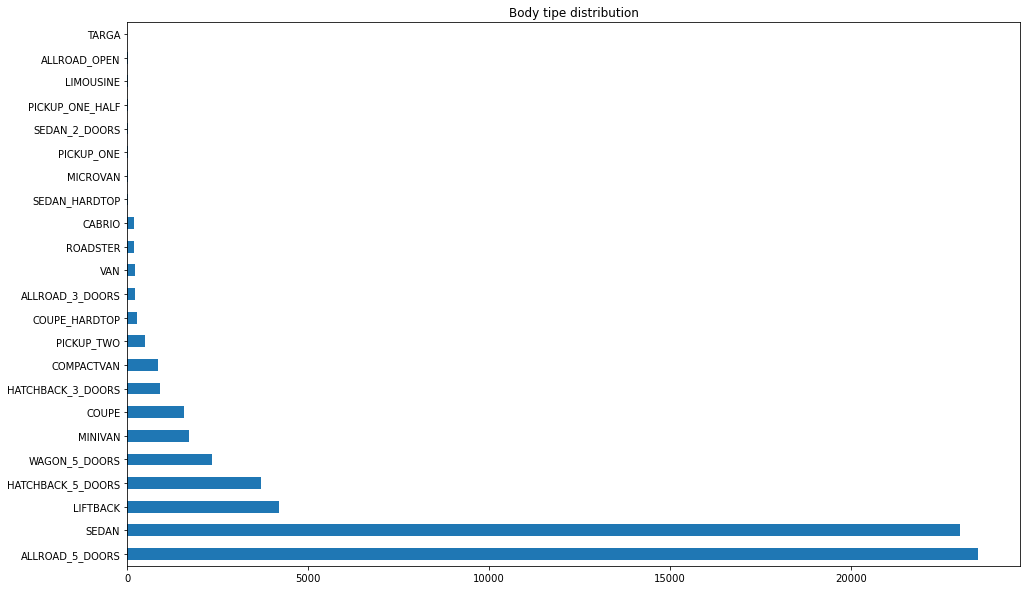

In [46]:
fig = plt.figure()
fig.set_size_inches(16, 10)
ax = fig.add_subplot(111)
ax.title.set_text('Body tipe distribution')
sum_df['body_type'].value_counts().plot.barh() 

### Пропуски

In [47]:
# Пропуски заменим на средние по модели
sum_df.isna().sum()

brand                 0
color                 0
mileage               0
model_date            0
model_name            0
number_of_doors       0
production_date       0
owners                0
pts_original          0
steering_wheel        0
body_type             0
displacement          0
engine_type           0
gear_type             0
transmission          0
power                 0
acceleration       2448
clearance_min       986
fuel_rate          5519
description         869
equipment_dict        0
sell_id               0
price                 0
dtype: int64

In [48]:
acceleration_dict = sum_df.groupby(['brand', 'model_name'])['acceleration'].mean().to_dict()
sum_df['acceleration'] = sum_df.apply(
    lambda row: row['acceleration'] if pd.notnull(row['acceleration']) else acceleration_dict[
        (row['brand'], row['model_name'])], 
    axis=1)

In [49]:
clearance_dict = sum_df.groupby(['brand', 'model_name'])['clearance_min'].mean().to_dict()
sum_df['clearance_min'] = sum_df.apply(
    lambda row: row['clearance_min'] if pd.notnull(row['clearance_min']) else clearance_dict[
        (row['brand'], row['model_name'])], 
    axis=1)

In [50]:
fuel_rate_dict = sum_df.groupby(['brand', 'model_name'])['fuel_rate'].mean().to_dict()
sum_df['fuel_rate'] = sum_df.apply(
    lambda row: row['fuel_rate'] if pd.notnull(row['fuel_rate']) else fuel_rate_dict[
        (row['brand'], row['model_name'])], 
    axis=1)

In [51]:
sum_df.isna().sum()

brand                0
color                0
mileage              0
model_date           0
model_name           0
number_of_doors      0
production_date      0
owners               0
pts_original         0
steering_wheel       0
body_type            0
displacement         0
engine_type          0
gear_type            0
transmission         0
power                0
acceleration       206
clearance_min        8
fuel_rate          347
description        869
equipment_dict       0
sell_id              0
price                0
dtype: int64

In [52]:
# Оставшиеся пропуски заменим на типичные для машин с таким кузовом
_dict = sum_df.groupby(['body_type'])['acceleration'].mean().to_dict()
sum_df['acceleration'] = sum_df.apply(
    lambda row: row['acceleration'] if pd.notnull(row['acceleration']) else _dict[row['body_type']], 
    axis=1)
_dict = sum_df.groupby(['body_type'])['clearance_min'].mean().to_dict()
sum_df['clearance_min'] = sum_df.apply(
    lambda row: row['clearance_min'] if pd.notnull(row['clearance_min']) else _dict[row['body_type']], 
    axis=1)
_dict = sum_df.groupby(['body_type'])['fuel_rate'].mean().to_dict()
sum_df['fuel_rate'] = sum_df.apply(
    lambda row: row['fuel_rate'] if pd.notnull(row['fuel_rate']) else _dict[row['body_type']], 
    axis=1)

In [53]:
sum_df.isna().sum()

brand                0
color                0
mileage              0
model_date           0
model_name           0
number_of_doors      0
production_date      0
owners               0
pts_original         0
steering_wheel       0
body_type            0
displacement         0
engine_type          0
gear_type            0
transmission         0
power                0
acceleration         0
clearance_min        0
fuel_rate            0
description        869
equipment_dict       0
sell_id              0
price                0
dtype: int64

In [54]:
# Оставшиеся пропуски заменим на типичные для машин с такой же мощностью
_dict = sum_df.groupby(['power'])['acceleration'].mean().to_dict()
sum_df['acceleration'] = sum_df.apply(
    lambda row: row['acceleration'] if pd.notnull(row['acceleration']) else _dict[row['power']], 
    axis=1)
_dict = sum_df.groupby(['power'])['fuel_rate'].mean().to_dict()
sum_df['fuel_rate'] = sum_df.apply(
    lambda row: row['fuel_rate'] if pd.notnull(row['fuel_rate']) else _dict[row['power']], 
    axis=1)

In [55]:
sum_df.isna().sum()

brand                0
color                0
mileage              0
model_date           0
model_name           0
number_of_doors      0
production_date      0
owners               0
pts_original         0
steering_wheel       0
body_type            0
displacement         0
engine_type          0
gear_type            0
transmission         0
power                0
acceleration         0
clearance_min        0
fuel_rate            0
description        869
equipment_dict       0
sell_id              0
price                0
dtype: int64

In [56]:
sum_df['description'] = sum_df['description'].fillna('')
sum_df.isna().sum()

brand              0
color              0
mileage            0
model_date         0
model_name         0
number_of_doors    0
production_date    0
owners             0
pts_original       0
steering_wheel     0
body_type          0
displacement       0
engine_type        0
gear_type          0
transmission       0
power              0
acceleration       0
clearance_min      0
fuel_rate          0
description        0
equipment_dict     0
sell_id            0
price              0
dtype: int64

### Целевая переменная

In [57]:
#!pip install -U seaborn

/Users/sand/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/sand/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


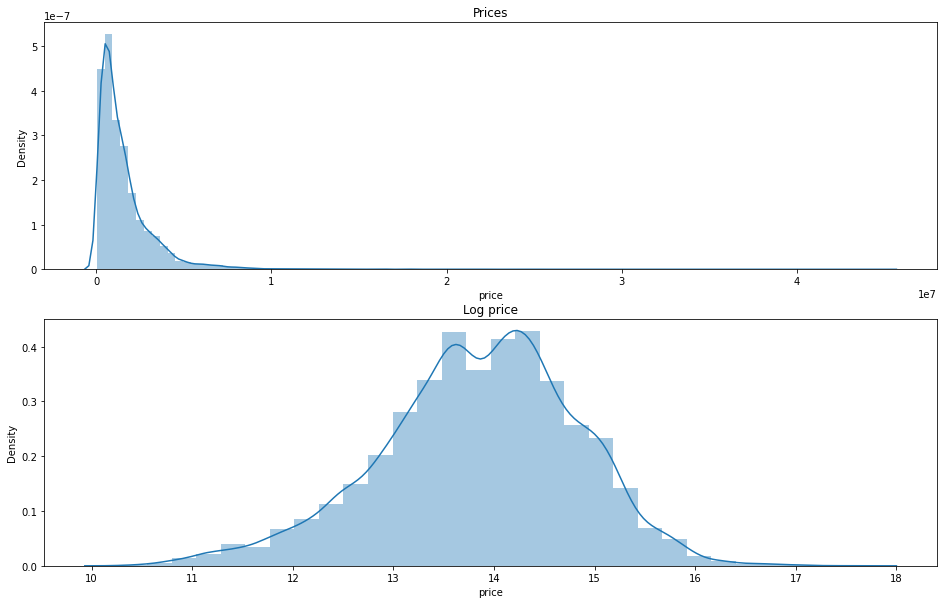

In [58]:
# Из всех признаков опасения вызывают экстремально высокие цены на авто
fig, ax = plt.subplots(nrows=2, ncols=1)
fig.set_size_inches(16, 10)
indices = sum_df['price'] > 0
ax[0].set_title('Prices')
_ = sns.distplot(sum_df.loc[indices, 'price'], kde=True, bins=100, ax=ax[0])
ax[1].set_title('Log price')
_ = sns.distplot(np.log(sum_df.loc[indices, 'price']), kde=True, bins=30, ax=ax[1])
#     ax[1][0].set_title('Sqrt')
#     _ = sns.histplot(np.sqrt(no_zero_df), fill=True, kde=True, bins=30, ax=ax[1][0])
#     ax[1][1].set_title('BoxCox')
#     _ = sns.histplot(stats.boxcox(df.loc[indices, target])[0], fill=True, kde=True, bins=30, ax=ax[1][1])


In [59]:
sum_df[sum_df['price'] > 20_000_000]

,brand,color,mileage,model_date,model_name,number_of_doors,production_date,owners,pts_original,steering_wheel,...,gear_type,transmission,power,acceleration,clearance_min,fuel_rate,description,equipment_dict,sell_id,price
4323,BMW,синий,30,1954,OTHER,4,1960,1,1,1,...,REAR_DRIVE,MECHANICAL,140,4.85,178.000000,9.242857,Цвет: темно-синий. Куплена в Германии (в компа...,{},0,22200000.0
8970,MERCEDES,чёрный,208,2014,V_KLASSE,5,2020,1,1,1,...,ALL_WHEEL_DRIVE,AUTOMATIC,190,9.10,160.000000,6.600000,Рестайлинг ставшего уже классическим набора оп...,"{'asr': True, 'tinted-glass': True, 'roller-bl...",0,20330000.0
9086,MERCEDES,чёрный,44800,2017,S_KLASSE,4,2017,1,1,1,...,REAR_DRIVE,AUTOMATIC,530,4.60,130.000000,11.600000,ЗАВОДСКОЙ БРОНИРОВАННЫЙ АВТОМОБИЛЬ !!! СТЕПЕНЬ...,"{'roller-blind-for-rear-window': True, 'esp': ...",0,25000000.0
9135,MERCEDES,чёрный,1,2014,V_KLASSE,5,2020,1,1,1,...,ALL_WHEEL_DRIVE,AUTOMATIC,190,9.10,160.000000,6.600000,Zart 91 Radiance\n\nПриобрести данный автомоби...,"{'cruise-control': True, 'esp': True, 'usb': T...",0,24900000.0
9367,MERCEDES,чёрный,27,2014,V_KLASSE,5,2020,1,1,1,...,ALL_WHEEL_DRIVE,AUTOMATIC,190,9.10,160.000000,6.600000,Салон автомобиля реально белый.,"{'asr': True, 'tinted-glass': True, 'roller-bl...",0,29800000.0
9368,MERCEDES,чёрный,32,2014,V_KLASSE,5,2020,1,1,1,...,ALL_WHEEL_DRIVE,AUTOMATIC,190,9.10,160.000000,6.600000,Выставочный экземпляр. На учёте не стоял.,"{'asr': True, 'tinted-glass': True, 'roller-bl...",0,27000000.0
9401,MERCEDES,чёрный,1,2014,V_KLASSE,5,2020,1,1,1,...,ALL_WHEEL_DRIVE,AUTOMATIC,190,9.10,160.000000,6.600000,Автомобиль готов к просмотру в нашем шоу-руме ...,"{'front-seats-heat-vent': True, 'wireless-char...",0,30850000.0
9597,MERCEDES,серый,6700,2018,G_KLASSE_AMG,5,2020,1,1,1,...,ALL_WHEEL_DRIVE,AUTOMATIC,585,4.50,266.000000,13.300000,"BRABUS 800 Limited Edition ""1 of 10"" на базе G...","{'cruise-control': True, 'esp': True, 'sport-s...",0,24000000.0
9698,MERCEDES,серый,5200,2010,SLS_AMG,2,2014,2,1,1,...,REAR_DRIVE,ROBOT,591,3.70,99.000000,13.200000,Последний год выпуска sls \nВерсия gt 597 атмо...,{},0,40000000.0
9701,MERCEDES,красный,4800,2010,SLS_AMG,2,2014,3,1,1,...,REAR_DRIVE,ROBOT,591,3.70,99.000000,13.200000,MERCEDES-BENZ SLS AMG GT ROADSTER FINAL EDITIO...,"{'cruise-control': True, 'esp': True, 'sport-s...",0,26000000.0


In [60]:
# Но высокие это люксовые марки Mercedes так что можно считеть, что такое может быть
# А BMW видимо раритетный, в тестовом наборе тоже есть раритетные машины
#!!! Припостроении модели прологарифмировать

### Корреляционный анализ

In [61]:
# Корреляция между числовыми признаками набора данных
def show_num_corr(df, features, title='Корреляция между данными'):
    plt.figure(figsize=(16, 10))
    mask = np.triu(np.ones_like(df[features].corr(), dtype=bool))
    heatmap = sns.heatmap(df[features].corr(),
                          mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
    heatmap = heatmap.set_title(title, fontdict={'fontsize': 18}, pad=16)    
    return heatmap


Text(0.5, 1.0, 'Корреляция между данными')

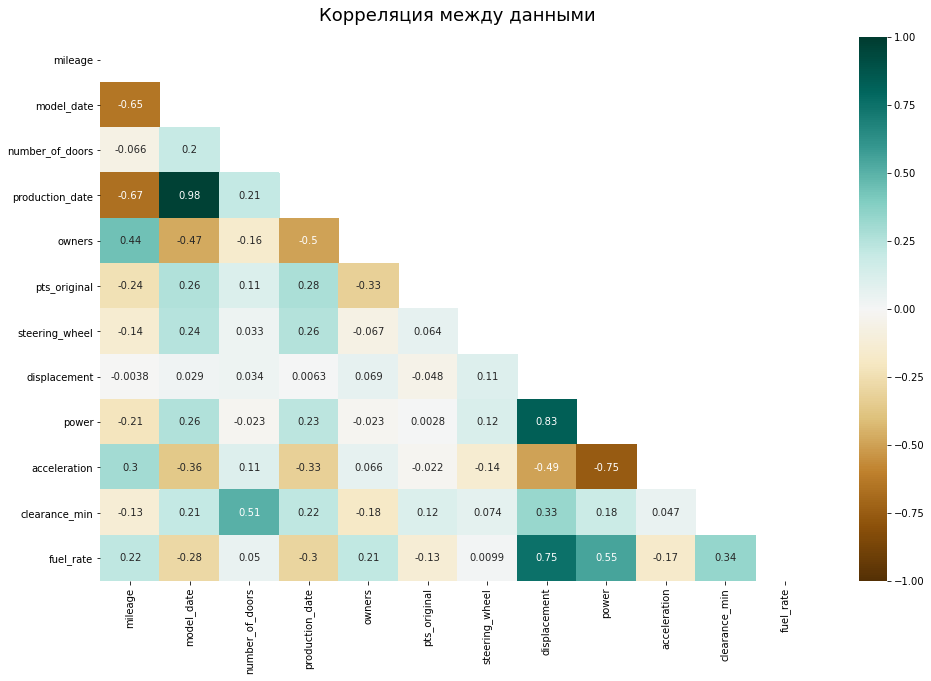

In [62]:
show_num_corr(sum_df, ['mileage', 'model_date', 'number_of_doors', 'production_date', 
                     'owners', 'pts_original', 'steering_wheel', 'displacement', 'power', 
                     'acceleration', 'clearance_min','fuel_rate'])

Text(0.5, 1.0, 'Корреляция между данными')

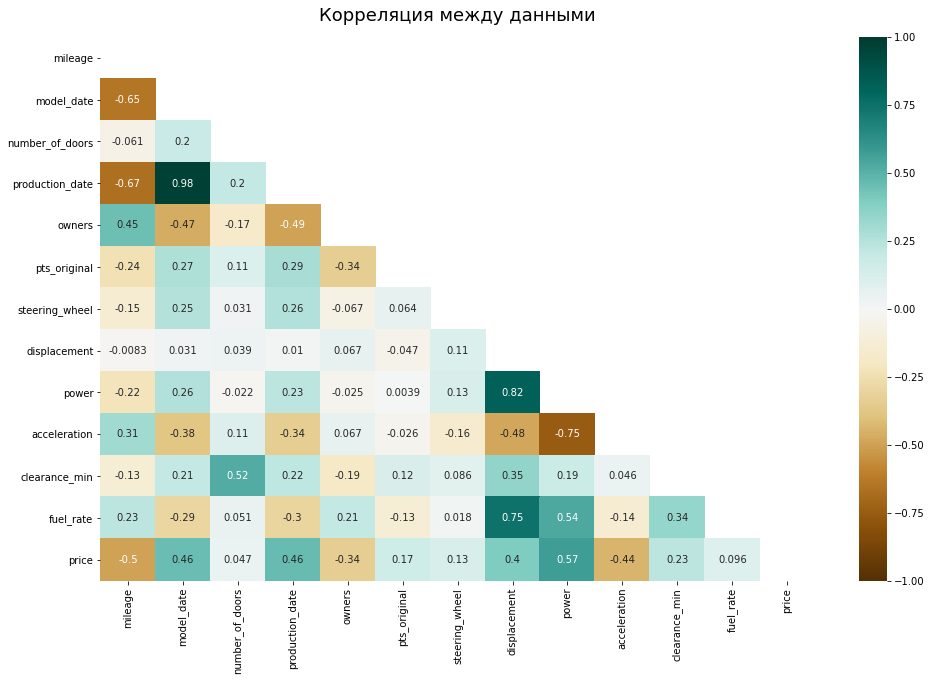

In [63]:
# Скорее всего нужно убрать либо model_date либо production_date
# Посмотрим на связь с целевой переменной
show_num_corr(sum_df[sum_df['price'] > 0], ['mileage', 'model_date', 'number_of_doors', 'production_date', 
                                          'owners', 'pts_original', 'steering_wheel', 'displacement', 'power', 
                                          'acceleration', 'clearance_min','fuel_rate', 'price'])

In [64]:
# вместо model_date сгенерируем признак - возраст модели
sum_df['model_age'] = sum_df['production_date'] - sum_df['model_date']
sum_df.drop('model_date', axis=1, inplace=True)

In [65]:
# Возможно лучше будет удалить объем двигателя
sum_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63440 entries, 0 to 28856
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            63440 non-null  object 
 1   color            63440 non-null  object 
 2   mileage          63440 non-null  int64  
 3   model_name       63440 non-null  object 
 4   number_of_doors  63440 non-null  int64  
 5   production_date  63440 non-null  int64  
 6   owners           63440 non-null  int64  
 7   pts_original     63440 non-null  int64  
 8   steering_wheel   63440 non-null  int64  
 9   body_type        63440 non-null  object 
 10  displacement     63440 non-null  int64  
 11  engine_type      63440 non-null  object 
 12  gear_type        63440 non-null  object 
 13  transmission     63440 non-null  object 
 14  power            63440 non-null  int64  
 15  acceleration     63440 non-null  float64
 16  clearance_min    63440 non-null  float64
 17  fuel_rate   

## Предобработка

In [66]:
rare_models = sum_df['model_name'].value_counts()[sum_df['model_name'].value_counts() < 3].index.values
rare_models
#sum_df['model_name'] = sum_df['model_name'].apply(lambda x: 'OTHER' if x in rare_models else x)

array(['LM', 'E_TRON', 'POLO_GTI', '300ZX', 'URVAN', '920', 'V8', 'PASEO',
       'IST', 'MAYBACH_GLS', 'Z3M', 'WILL_CYPHA', 'Z1', 'FTO', 'W188',
       'W114', 'FAIRLADY_Z', 'SLR_KLASSE', 'OTTI', 'TERRANO_REGULUS',
       'MASTER_ACE_SURF', 'LANCER_RALLIART'], dtype=object)

In [67]:
# Избавимся от дубликатов в трейне
train_df = sum_df[sum_df['price'] > 0]
test_df = sum_df[sum_df['price'] == 0]
columns4dup = list(train_df.columns.values)
columns4dup.remove('equipment_dict')
print('Кол-во дубликатов в трейне до удаления:', train_df.duplicated(subset=columns4dup).sum())
train_df= train_df.drop_duplicates(subset=columns4dup)
print('Кол-во дубликатов в трейне после удаления:', train_df.duplicated(subset=columns4dup).sum())
sum_df = pd.concat([test_df, train_df])
sum_df.info()

Кол-во дубликатов в трейне до удаления: 233
Кол-во дубликатов в трейне после удаления: 0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 63207 entries, 0 to 28856
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   brand            63207 non-null  object 
 1   color            63207 non-null  object 
 2   mileage          63207 non-null  int64  
 3   model_name       63207 non-null  object 
 4   number_of_doors  63207 non-null  int64  
 5   production_date  63207 non-null  int64  
 6   owners           63207 non-null  int64  
 7   pts_original     63207 non-null  int64  
 8   steering_wheel   63207 non-null  int64  
 9   body_type        63207 non-null  object 
 10  displacement     63207 non-null  int64  
 11  engine_type      63207 non-null  object 
 12  gear_type        63207 non-null  object 
 13  transmission     63207 non-null  object 
 14  power            63207 non-null  int64  
 15  acceleration   

In [68]:
# sum_df.drop(['description', 'equipment_dict'], axis=1, inplace=True)
# Итерация 1 на стекинге результат mape = 0.1342327982988012 без 'description', 'equipment_dict'
# Теперь добавим оборудование
sum_df['equipment_list'] = sum_df['equipment_dict'].apply(lambda x: [k for k, v in x.items()])
sum_df.head()

,brand,color,mileage,model_name,number_of_doors,production_date,owners,pts_original,steering_wheel,body_type,...,power,acceleration,clearance_min,fuel_rate,description,equipment_dict,sell_id,price,model_age,equipment_list
0,SKODA,синий,74000,OCTAVIA,5,2014,3,1,1,LIFTBACK,...,105,10.5,155.0,5.0,"Все автомобили, представленные в продаже, прох...","{'engine-proof': True, 'tinted-glass': True, '...",1100575026,0.0,1,"[engine-proof, tinted-glass, airbag-driver, au..."
1,SKODA,чёрный,60563,OCTAVIA,5,2017,1,1,1,LIFTBACK,...,110,10.8,156.0,6.4,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,"{'cruise-control': True, 'asr': True, 'esp': T...",1100549428,0.0,0,"[cruise-control, asr, esp, airbag-driver, isof..."
2,SKODA,серый,88000,SUPERB,5,2014,1,1,1,LIFTBACK,...,152,8.7,139.0,7.1,"Все автомобили, представленные в продаже, прох...","{'cruise-control': True, 'tinted-glass': True,...",1100658222,0.0,1,"[cruise-control, tinted-glass, esp, adaptive-l..."
3,SKODA,коричневый,95000,OCTAVIA,5,2014,1,1,1,LIFTBACK,...,110,12.2,155.0,6.7,КОМПЛЕКТ ЗИМНЕЙ (ЛЕТНЕЙ) РЕЗИНЫ ПО СЕЗОНУ В ПО...,"{'cruise-control': True, 'roller-blind-for-rea...",1100937408,0.0,1,"[cruise-control, roller-blind-for-rear-window,..."
4,SKODA,белый,58536,OCTAVIA,5,2012,1,1,1,LIFTBACK,...,152,8.8,164.0,7.7,ЛОТ: 01220889\nАвтопрага Север\n\nВы можете по...,"{'cruise-control': True, 'asr': True, 'esp': T...",1101037972,0.0,4,"[cruise-control, asr, esp, airbag-driver, isof..."


In [69]:
# Encoding для equipments
mlb = MultiLabelBinarizer()
mlb.fit(sum_df['equipment_list'])
classes = ['equip_' + clazz.replace(' ', '_') for clazz in mlb.classes_]
data = mlb.transform(sum_df['equipment_list'])
for i in range(0, len(classes)):
    sum_df[classes[i]] = data[:, i]
sum_df.head()

,brand,color,mileage,model_name,number_of_doors,production_date,owners,pts_original,steering_wheel,body_type,...,equip_wheel-configuration3,equip_wheel-heat,equip_wheel-leather,equip_wheel-memory,equip_wheel-power,equip_windcleaner-heat,equip_windscreen-heat,equip_wireless-charger,equip_xenon,equip_ya-auto
0,SKODA,синий,74000,OCTAVIA,5,2014,3,1,1,LIFTBACK,...,0,0,0,0,1,0,0,0,0,0
1,SKODA,чёрный,60563,OCTAVIA,5,2017,1,1,1,LIFTBACK,...,0,1,0,0,1,0,1,0,0,0
2,SKODA,серый,88000,SUPERB,5,2014,1,1,1,LIFTBACK,...,0,0,1,0,1,0,1,0,1,0
3,SKODA,коричневый,95000,OCTAVIA,5,2014,1,1,1,LIFTBACK,...,0,0,0,0,1,0,1,0,0,0
4,SKODA,белый,58536,OCTAVIA,5,2012,1,1,1,LIFTBACK,...,0,0,0,0,1,0,0,0,0,0


In [70]:
# Теперь уберем слишком редко или слишком часто встречающееся оборудование (<0.05)
equip_columns = [c for c in sum_df.columns if c.startswith('equip_')]
arr = []
for c in equip_columns:
    ones = sum(sum_df[c] == 1)
    zeros = sum(sum_df[c] == 0)
    arr.append((c, ones, zeros, ones / zeros, zeros / ones))
for c, ones, zeros, p1, p2 in arr:
    if p1 < 0.05 or p2 < 0.05:
        sum_df.drop(c, axis=1, inplace=True)

In [71]:
sum_df.head()

,brand,color,mileage,model_name,number_of_doors,production_date,owners,pts_original,steering_wheel,body_type,...,equip_usb,equip_voice-recognition,equip_volume-sensor,equip_wheel-configuration1,equip_wheel-configuration2,equip_wheel-heat,equip_wheel-leather,equip_wheel-power,equip_windscreen-heat,equip_xenon
0,SKODA,синий,74000,OCTAVIA,5,2014,3,1,1,LIFTBACK,...,0,0,0,1,1,0,0,1,0,0
1,SKODA,чёрный,60563,OCTAVIA,5,2017,1,1,1,LIFTBACK,...,1,0,0,0,1,1,0,1,1,0
2,SKODA,серый,88000,SUPERB,5,2014,1,1,1,LIFTBACK,...,0,0,0,1,1,0,1,1,1,1
3,SKODA,коричневый,95000,OCTAVIA,5,2014,1,1,1,LIFTBACK,...,1,0,0,1,1,0,0,1,1,0
4,SKODA,белый,58536,OCTAVIA,5,2012,1,1,1,LIFTBACK,...,0,0,0,0,1,0,0,1,0,0


In [72]:
sum_df.drop(['description', 'equipment_dict', 'equipment_list'], axis=1, inplace=True)

In [73]:
# чтобы профайлер не запускался каждый раз
if not SUBMIT_MODE and not os.path.exists("sum_profile_equip.html"):
    profile_train = ProfileReport(sum_df, title="Pandas Profiling Report")
    profile_train.to_file("sum_profile_equip.html")
    profile_train.to_notebook_iframe()

In [74]:
# Сохраним полученный датасет
if os.path.exists('train_test.csv'):
    os.remove('train_test.csv')
sum_df.to_csv('train_test.csv')

## Наивная модель

In [75]:
df = pd.read_csv('train_test.csv', index_col=0)

In [76]:
%%time
# Возьмем среднее по модели и году выпуска
X_train, X_val, y_train, y_val = train_test_split(df[df['price'] > 0].drop('price', axis=1),
                                                  df[df['price'] > 0]['price'], 
                                                  test_size=0.25, random_state=RANDOM_SEED)
naive_train_df = X_train.copy()
naive_train_df['price'] = y_train
mean_price_model = naive_train_df.groupby(['brand', 'model_name', 'production_date'])['price'].mean()
mean_price_pdate = naive_train_df.groupby(['brand', 'production_date'])['price'].mean()
mean_price_brand = naive_train_df.groupby(['brand'])['price'].mean()

def predict(row):
    try:
        return mean_price_model[(row['brand'], row['model_name'], row['production_date'])]
    except KeyError:
        try:
            return mean_price_pdate[(row['brand'], row['production_date'])]
        except KeyError:
            return mean_price_brand[row['brand']]
        
y_pred = X_val.apply(lambda row: predict(row), axis=1)
print('MAPE:', mape(y_val, y_pred))

MAPE: 0.2303434521554341
CPU times: user 400 ms, sys: 17.1 ms, total: 417 ms
Wall time: 420 ms


## Подготовка данных к обучению

In [77]:
df = pd.read_csv('train_test.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63207 entries, 0 to 28856
Columns: 138 entries, brand to equip_xenon
dtypes: float64(4), int64(127), object(7)
memory usage: 67.0+ MB


In [78]:
def prepare_train_test(train, test, scaler=None):
    """
    Функция для подготовки данных трейна и теста, чтобы использовать ее и для валидации модели
    и для получения предсказаний на тесте принимает уже разделенный на тест и трейн набор
    """
    # Group features
    cat_features = ['brand', 'color', 'model_name', 'body_type', 'engine_type', 'gear_type', 'transmission']
    bin_features = ['pts_original', 'steering_wheel']
    num_features = ['mileage', 'number_of_doors', 'production_date', 'owners', 'displacement', 'power', 
                    'acceleration', 'clearance_min', 'fuel_rate', 'model_age'] 
    target = 'price'
    train_df = train.drop('sell_id', axis=1).copy()
    test_df = test.drop('sell_id', axis=1).copy()
    if 'price' not in test_df.columns:
        test_df['price'] = 0
    train_df['is_train'] = True
    test_df['is_train'] = False
    df = pd.concat([train_df, test_df], axis=0)
    # Encode cat features
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(df[cat_features])
    cat_df = pd.DataFrame(encoder.transform(df[cat_features]), 
                           columns=encoder.get_feature_names(cat_features),
                           index=df.index).astype(int)
    df = pd.concat([cat_df, df.drop(cat_features, axis=1)], axis=1)
    
    # Scale num features
    if scaler is not None:
        df[df['is_train']][num_features] = scaler.fit_transform(df[df['is_train']][num_features])
        df[not df['is_train']][num_features] = scaler.fit_transform(df[not df['is_train']][num_features])
        
    X_train = df[(df['is_train'] == True)].drop(['is_train', target], axis=1)
    X_test = df[(df['is_train'] == False)].drop(['is_train', target], axis=1)
    y_train = df[(df['is_train'] == True)][target]
    y_test = df[(df['is_train'] == False)][target]
    return X_train, X_test, y_train, y_test


In [79]:
class CarPrice():
    """
    Небольшой класс для проверки метрик по моделям
    """
    # Group features
    cat_features = ['brand', 'color', 'model_name', 'body_type', 'engine_type', 'gear_type', 'transmission']
    bin_features = ['pts_original', 'steering_wheel']
    num_features = ['mileage', 'number_of_doors', 'production_date', 'owners', 'displacement', 'power', 
                    'acceleration', 'clearance_min', 'fuel_rate', 'model_age'] 
    target = 'price'
    
    def __init__(self, train, test):
        self._X_train = train.drop(self.target, axis=1).copy()
        self._y_train = train[self.target]
        if self.target in test.columns:
            self._X_test = test.drop(self.target, axis=1).copy()
            self._y_test = test[self.target]
        else:
            self._X_test = test.copy()
            self._y_test = None
        
    def get_X(self):
        return self._X_train

    def get_y(self):
        return self._y_train
        
    def scale(self, scaler):
        assert(scaler is not None)
        self._X_train[self.num_features] = scaler.fit_transform(self._X_train[self.num_features])
        self._X_test[self.num_features] = scaler.fit_transform(self._X_test[self.num_features])
        return self
    
    def fit_predict(self, model):
        assert(model is not None)
        model.fit(self._X_train, np.log(self._y_train))
        return np.exp(model.predict(self._X_test))
    
    def fit_print_metrics(self, model):
        assert(self._y_test is not None)
        metrics = dict()
        y_pred = self.fit_predict(model)
        metrics['mape'] = mape(self._y_test, y_pred)
        for key, val in metrics.items():
            print(f'{key} = {val}')
        return metrics

In [80]:
class CarPriceOneHot(CarPrice):
    def __init__(self, train, test):
        super().__init__(train, test)
        
    def encode(self):
        self._X_train['is_train'] = True
        self._X_test['is_train'] = False
        union_df = pd.concat([self._X_train, self._X_test])
        encoder = OneHotEncoder(sparse=False)
        encoder.fit(union_df[cat_features])
        cat_df = pd.DataFrame(encoder.transform(union_df[cat_features]), 
                              columns=encoder.get_feature_names(cat_features),
                              index=union_df.index).astype(int)
        union_df = pd.concat([cat_df, union_df.drop(cat_features, axis=1)], axis=1)
        self._X_train = union_df[union_df['is_train'] == True]
        self._X_test = union_df[union_df['is_train'] == False]
        return self
    
    def generate_poly(self, degree=2, interaction_only=False):
        poly = PolynomialFeatures(degree=degree, interaction_only=interaction_only, include_bias=False)
        poly_train = poly.fit_transform(self._X_train[self.num_features])
        poly_test = poly.fit_transform(self._X_test[self.num_features])
        columns = [f.replace(' ', '*') for f in poly.get_feature_names()]
        for i in range(0, len(self.num_features)):
            columns = [c.replace(f'x{i}', self.num_features[i]) for c in columns]
        for i in range(0, len(columns)):
            if '^' not in columns[i]:
                self._X_train[columns[i]] = poly_train[:, i]
                self._X_test[columns[i]] = poly_test[:, i]
        return self
        
    def generate_features(self):
#         self._X_train['displacement*power'] = self._X_train['displacement'] * self._X_train['power']
#         self._X_test['displacement*power'] = self._X_test['displacement'] * self._X_test['power']
#         self.num_features.append('displacement*power')
        return self

    def log_features(self):
        for f in self.num_features:
            if sum(self._X_train[f] <= 0) == 0 and sum(self._X_test[f] <= 0) == 0:
                self._X_train[f] = np.log(self._X_train[f])
                self._X_test[f] = np.log(self._X_test[f])
        return self


In [81]:
#reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
#X_train, X_val, y_train, y_val = prepare_train_test(df[df['price'] > 0], scaler=StandardScaler()) 
#models, predictions = reg.fit(X_train, X_val, y_train, y_val)
#print(models)

## RandomForestRegressor

In [82]:
%%time
## Without scaler
model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, n_estimators=200)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, test_df).encode().generate_features().log_features()
#car_price.get_X()
car_price.fit_print_metrics(model)

mape = 0.14299206674638737
CPU times: user 3min 13s, sys: 3.05 s, total: 3min 16s
Wall time: 36.4 s


{'mape': 0.14299206674638737}

In [83]:
def plot_feature_imortances(fi, columns, num=20):
    plt.rcParams['figure.figsize'] = (10, 10)
    feat_importances = pd.Series(model.feature_importances_, index=car_price.get_X().columns)
    mean_imp = feat_importances.nlargest(num).mean()
    feat_colors = feat_importances.apply(lambda x: 'r' if x > mean_imp else 'b')
    feat_importances.nlargest(num).plot(kind='barh', title='Feature importance')


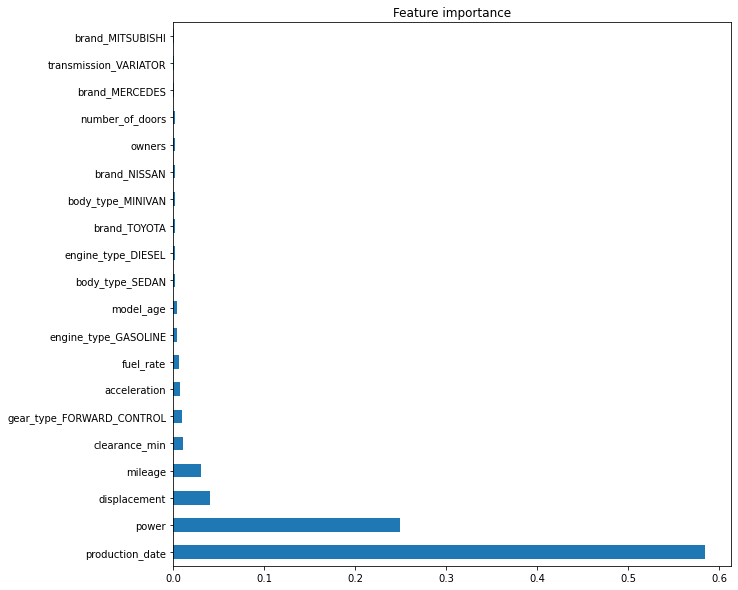

In [84]:
plot_feature_imortances(model.feature_importances_, car_price.get_X().columns)

## XGBRegressor

In [85]:
%%time
## Without scaler
model = xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, max_depth=5, n_estimators=200)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, test_df).encode().generate_features().log_features()
car_price.fit_print_metrics(model)

mape = 0.14341951436945272
CPU times: user 3min 5s, sys: 2.18 s, total: 3min 7s
Wall time: 32.7 s


{'mape': 0.14341951436945272}

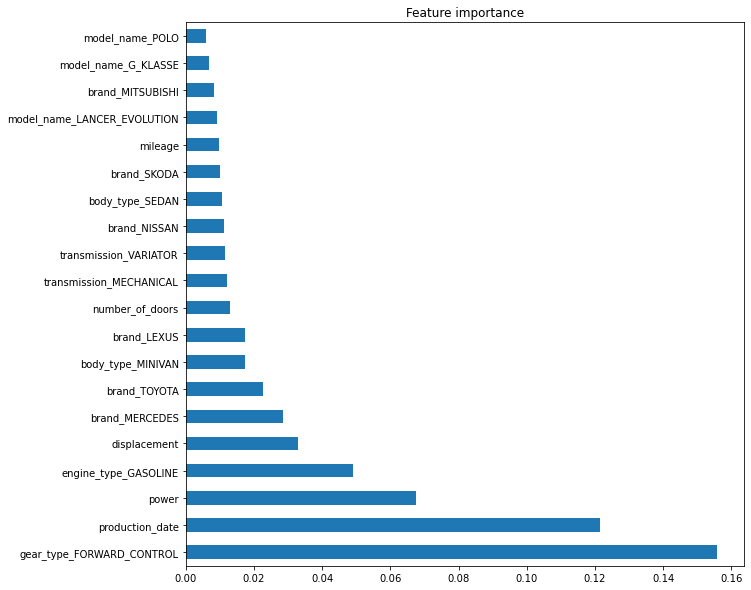

In [86]:
plot_feature_imortances(model.feature_importances_, car_price.get_X().columns)

In [87]:
import optuna
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, test_df).encode()
data = car_price.get_X()
target = car_price.get_y()
def objective(trial, data=data, target=target):    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=VAL_SIZE, random_state=RANDOM_SEED)
    param = {
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 10.0),
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300, 500]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17,20]),
        'random_state': trial.suggest_categorical('random_state', [RANDOM_SEED]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
    }
    model = xgb.XGBRegressor(**param)  
    train_y = np.log(train_y)
    model.fit(train_x, train_y, eval_set=[(test_x,test_y)], early_stopping_rounds=100, verbose=False)
    preds = model.predict(test_x)
    return mape(test_y, np.exp(preds))

In [88]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

In [89]:
#optuna.visualization.plot_optimization_history(study)

In [90]:
#optuna.visualization.plot_parallel_coordinate(study)

In [91]:
#optuna.visualization.plot_slice(study)

In [92]:
# optuna.visualization.plot_contour(study, params=['alpha',
#                             #'max_depth',
#                             'lambda',
#                             'learning_rate'])

In [93]:
%%time
## Without scaler
model = xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, reg_lambda=0.1,
                         alpha=0.5, learning_rate=0.1, n_estimators=200, max_depth=7) 
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, test_df).encode()
car_price.fit_print_metrics(model)

mape = 0.14035554531276867
CPU times: user 4min 16s, sys: 2.32 s, total: 4min 18s
Wall time: 42.3 s


{'mape': 0.14035554531276867}

## ExtraTreesRegressor

In [94]:
%%time
## Without scaler
model = ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True, n_estimators=200)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, test_df).encode()
car_price.fit_print_metrics(model)

mape = 0.14270899632509038
CPU times: user 1min 37s, sys: 924 ms, total: 1min 38s
Wall time: 1min 38s


{'mape': 0.14270899632509038}

In [95]:
# grid = {'n_estimators': [100, 200],
#         'min_samples_leaf': [1, 2, 3, 4]}
# model = ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True, n_jobs=-1)
# gsc = GridSearchCV(
#     estimator=model,
#     param_grid=grid,
#     cv=5
# )
# train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
# car_price = CarPriceOneHot(train_df)
# gsc.fit(car_price.get_X(), car_price.get_y())
# car_price.fit(gsc.best_estimator_)
# car_price.print_metrics(test_df)

## CatBoostRegressor

In [96]:
%%time
## Without scaler
model = CatBoostRegressor(iterations=200, depth=7, learning_rate=0.5, loss_function='MAPE', 
                          verbose=0, random_state=RANDOM_SEED)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, test_df).encode()
car_price.fit_print_metrics(model)

mape = 0.14495029638558005
CPU times: user 8.82 s, sys: 817 ms, total: 9.64 s
Wall time: 2.83 s


{'mape': 0.14495029638558005}

In [97]:
# grid = {'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
#         'depth': [4, 5, 6, 7, 8, 9],
#         'l2_leaf_reg': [1, 2, 3, 4, 5, 6, 7, 8, 9]}

# train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
# car_price = CarPriceOneHot(train_df)
# model = CatBoostRegressor(loss_function='MAPE', verbose=0, random_state=RANDOM_SEED)
# grid_search_result = model.grid_search(grid, 
#                                        X=car_price.get_X(), 
#                                        y=np.log(car_price.get_y()), 
#                                        plot=True)


In [98]:
#grid_search_result['params']

In [99]:
%%time
## Without scaler
model = CatBoostRegressor(depth=6, learning_rate=0.1, l2_leaf_reg=9,
                          loss_function='MAPE', verbose=0, random_state=RANDOM_SEED)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, test_df).encode()
car_price.fit_print_metrics(model)

mape = 0.13177248606318487
CPU times: user 28.7 s, sys: 2.76 s, total: 31.5 s
Wall time: 8.96 s


{'mape': 0.13177248606318487}

## Bagging

In [100]:
%%time
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import ExtraTreeRegressor
base_estimator=ExtraTreeRegressor(random_state=RANDOM_SEED)
model = BaggingRegressor(base_estimator=base_estimator, n_estimators=20, 
                         bootstrap_features=False, random_state=RANDOM_SEED)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, test_df).encode()
car_price.fit_print_metrics(model)

mape = 0.15311236742555961
CPU times: user 19.4 s, sys: 405 ms, total: 19.8 s
Wall time: 20 s


{'mape': 0.15311236742555961}

In [101]:
%%time
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LassoCV
base_estimator=LassoCV(random_state=RANDOM_SEED)
model = BaggingRegressor(base_estimator=base_estimator, n_estimators=10, random_state=RANDOM_SEED)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, test_df).encode().scale(StandardScaler())
car_price.fit_print_metrics(model)

mape = 0.2062970912835111
CPU times: user 2min 8s, sys: 15.8 s, total: 2min 23s
Wall time: 1min 3s


{'mape': 0.2062970912835111}

In [102]:
%%time
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LassoCV
base_estimator=LassoCV(random_state=RANDOM_SEED)
model = BaggingRegressor(base_estimator=base_estimator, n_estimators=10, random_state=RANDOM_SEED)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, test_df).encode().scale(MinMaxScaler())
car_price.fit_print_metrics(model)

mape = 0.19639202452903537
CPU times: user 4min 3s, sys: 32.3 s, total: 4min 35s
Wall time: 1min 40s


{'mape': 0.19639202452903537}

In [103]:
%%time
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
base_estimator=RidgeCV()
model = BaggingRegressor(base_estimator=base_estimator, n_estimators=10, random_state=RANDOM_SEED)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, test_df).encode().scale(MinMaxScaler())
car_price.fit_print_metrics(model)

mape = 0.16838416675818885
CPU times: user 59.7 s, sys: 5.22 s, total: 1min 4s
Wall time: 23.1 s


{'mape': 0.16838416675818885}

## Stacking

In [104]:
%%time
from sklearn.ensemble import StackingRegressor
models = [
    ('xgb', xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, max_depth=5, n_estimators=200)),
    ('extra_tree', ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True)),
    ('cat_boost', CatBoostRegressor(depth=6, learning_rate=0.1, l2_leaf_reg=9, loss_function='MAPE', 
                                    verbose=0, random_state=RANDOM_SEED)),
#    ('rf', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, n_estimators=200))
]
final_model = RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, n_estimators=200)
model = StackingRegressor(estimators=models, final_estimator=final_model,
                          cv=5, passthrough=True, verbose=2)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, test_df).encode()
car_price.fit_print_metrics(model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   38.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.0s finished


mape = 0.13125997940241435
CPU times: user 27min 13s, sys: 28 s, total: 27min 41s
Wall time: 8min 9s


{'mape': 0.13125997940241435}

In [105]:
%%time
from sklearn.ensemble import StackingRegressor
models = [
    ('xgb', xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, max_depth=5, n_estimators=200)),
#    ('extra_tree', ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True)),
    ('cat_boost', CatBoostRegressor(depth=6, learning_rate=0.1, l2_leaf_reg=9, loss_function='MAPE', 
                                    verbose=0, random_state=RANDOM_SEED)),
    ('rf', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, n_estimators=200))
]
final_model = ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True)
model = StackingRegressor(estimators=models, final_estimator=final_model,
                          cv=5, passthrough=True, verbose=2)
train_df, test_df = train_test_split(df[df['price'] > 0], test_size=VAL_SIZE, random_state=RANDOM_SEED)
car_price = CarPriceOneHot(train_df, test_df).encode()
car_price.fit_print_metrics(model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   23.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   24.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.0min finished


mape = 0.13068761496021183
CPU times: user 19min 4s, sys: 22.9 s, total: 19min 27s
Wall time: 6min 54s


{'mape': 0.13068761496021183}

In [106]:
from sklearn.ensemble import StackingRegressor
models = [
    ('xgb', xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1, max_depth=5, n_estimators=200)),
#    ('extra_tree', ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True)),
    ('cat_boost', CatBoostRegressor(depth=6, learning_rate=0.1, l2_leaf_reg=9, loss_function='MAPE', 
                                    verbose=0, random_state=RANDOM_SEED)),
    ('rf', RandomForestRegressor(random_state=RANDOM_SEED, n_jobs=-1, n_estimators=200))
]
final_model = ExtraTreesRegressor(random_state=RANDOM_SEED, bootstrap=True)
model = StackingRegressor(estimators=models, final_estimator=final_model,
                          cv=5, passthrough=True, verbose=2)
train_df, test_df = (df[df['price'] > 0], df[df['price'] == 0])
car_price = CarPriceOneHot(train_df, test_df).encode()
y_pred = car_price.fit_predict(model)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.7min finished


In [107]:
submission = df[df['price'] == 0][['sell_id']]
submission['price'] = (y_pred * 0.9)
submission.to_csv(f'submission.csv', index=False)
submission.head(10)

,sell_id,price
0,1100575026,6.177151e+05
1,1100549428,1.004210e+06
2,1100658222,8.538163e+05
3,1100937408,8.387012e+05
4,1101037972,6.513587e+05
5,1100912634,7.644767e+05
6,1101228730,6.346569e+05
7,1100165896,3.582239e+05
8,1100768262,1.854573e+06
9,1101218501,7.230691e+05


In [137]:
# Из набора в базовом решении получим средний прирост цен по моделям
# df2020 = pd.read_csv('all_auto_ru_09_09_2020.csv')
#df2020 = df2020[['brand', 'model', 'productionDate', 'mileage', 'price']]
#df2020.columns = ['brand', 'model_name', 'production_date', 'mileage', 'price']
# on=['brand', 'model_name', 'production_date', 'mileage']
# merged_df = check_df.merge(train_df, left_on=on, right_on=on)
# merged_df['price_diff'] = (merged_df['price_y']  - merged_df['price_x']) / merged_df['price_y']
# diff_by_brand = merged_df.groupby('brand')['price_diff'].mean().to_dict()
diff_by_brand = {
 'AUDI': 0.05960492889225346,
 'BMW': 0.1266654162819937,
 'HONDA': 0.10254400792996447,
 'INFINITI': 0.14075709751506446,
 'LEXUS': 0.0809377567145157,
 'MERCEDES': 0.12201344143747266,
 'MITSUBISHI': 0.11539314028554955,
 'NISSAN': 0.09564299896755538,
 'SKODA': 0.16034701981619512,
 'TOYOTA': 0.12734544830375857,
 'VOLKSWAGEN': 0.09443248432103783,
 'VOLVO': 0.0699287327224045    
}
test_df = df[df['price'] == 0].copy()
test_df['price'] = y_pred
test_df['old_price'] = test_df.apply(lambda row: row['price'] - row['price'] * diff_by_brand[row['brand']], axis=1)
submission = test_df[['sell_id', 'old_price']]
submission.columns = ['sell_id', 'price']
submission.to_csv(f'submission_2020.csv', index=False)
submission.head(10)

,sell_id,price
0,1100575026,5.762959e+05
1,1100549428,9.368757e+05
2,1100658222,7.965660e+05
3,1100937408,7.824644e+05
4,1101037972,6.076837e+05
5,1100912634,7.132168e+05
6,1101228730,5.921018e+05
7,1100165896,3.342042e+05
8,1100768262,1.730220e+06
9,1101218501,6.745857e+05
